In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


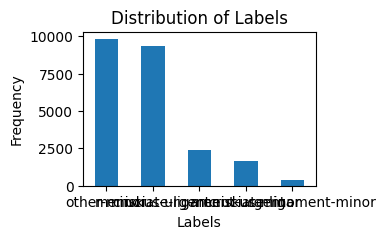

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
epochs = 3
model_name = "lr_finder"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, _, embedding_dim, lstm_units, _, batch_size = get_standard_parameters()

2024-07-26 10:29:10.011992: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-26 10:29:10.012038: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-26 10:29:10.012061: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-26 10:29:10.012646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-26 10:29:10.012681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import numpy as np
import keras.backend as K

class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-5, max_lr=1, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.lr_increment = (max_lr - min_lr) / self.total_iterations
        self.iteration = 0
        self.lrs = []
        self.losses = []

    def on_batch_begin(self, batch, logs=None):
        lr = self.min_lr + self.iteration * self.lr_increment
        self.model.optimizer.learning_rate.assign(lr)
        self.lrs.append(lr)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.iteration += 1
        self.losses.append(logs.get('loss'))
        if self.iteration > 5 and logs.get('loss') > 4 * min(self.losses):
            self.model.stop_training = True

    def get_best_lr(self):
        if self.losses:
            min_loss_idx = np.argmin(self.losses)  # Get the index of the minimum loss
            return self.lrs[min_loss_idx]  # Return the corresponding learning rate
        else:
            return None  # Return None if no losses were recorded


    def plot_lr(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

# Usage:
lr_finder = LearningRateFinder(min_lr=1e-5, max_lr=10, steps_per_epoch=np.ceil(len(train_padded)/32), epochs=3)


# Model definition and training

In [6]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [7]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[lr_finder])

Epoch 1/3


2024-07-26 10:29:11.004235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 145s 193ms/step - accuracy: 0.2012 - auc: 0.5754 - f1_score: 0.1272 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 2/3
736/736 ━━━━━━━━━━━━━━━━━━━━ 141s 192ms/step - accuracy: 0.0167 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 3/3
736/736 ━━━━━━━━━━━━━━━━━━━━ 141s 192ms/step - accuracy: 0.0155 - auc: 0.5000 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: nan


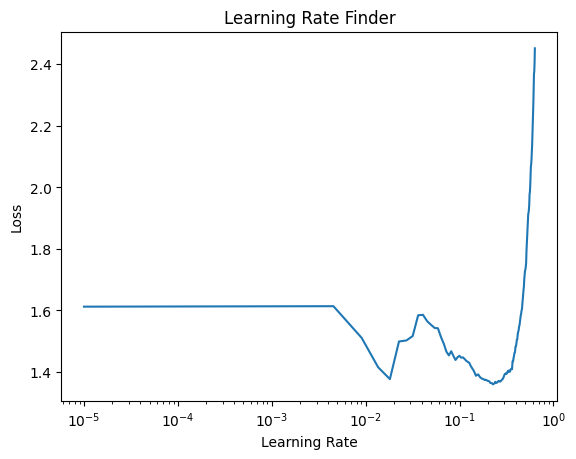

In [8]:
lr_finder.plot_lr()

In [12]:
lr_finder.get_best_lr()

0.6385963179347827

In [9]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to models/lr_finder/lr_finder.h5
Data saved


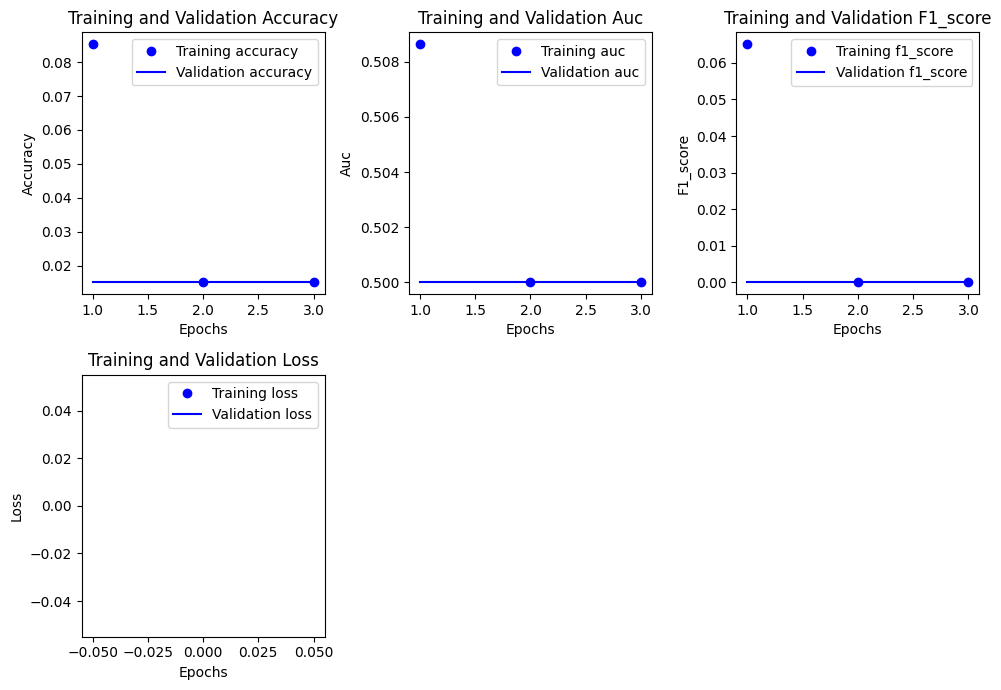

In [10]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step


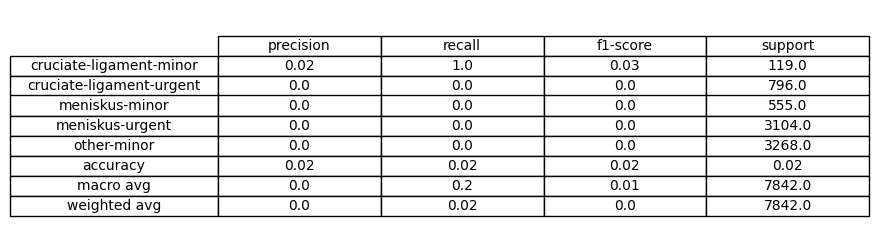

In [11]:
eval(model, test_padded, test_labels, label_encoder)